### MNIST Model and Misclassified Images

In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
#tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import alibi
import matplotlib
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  True


In [2]:
print(alibi.__version__)

0.7.0


In [3]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
#plt.imshow(x_test[15]);

x_train shape: (60000, 28, 28) y_train shape: (60000,)


<Figure size 432x288 with 0 Axes>

In [4]:
# loading etc
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
#normalizing
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

### Evaluate MC-Model on Test Set

In [6]:
cnn=load_model('cnn_mnist.h5')
cnn_mc = load_model('cnn_mnist_mc.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test accuracy:  0.989300012588501


In [7]:
y_pred = cnn.predict(x_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
misclassification_indices = list(np.where(np.argmax(y_pred, axis=1) != np.argmax(y_test, axis=1))[0]) #misclassifications

In [9]:
misclassified_images = []

for index in misclassification_indices:
    misclassified_images.append(x_test[index])
    

In [10]:
misclassified_images = np.array(misclassified_images)
misclassified_images.shape #i.e network misclassifies 107 28x28 mnist images

(107, 28, 28, 1)

### Reloading User-Edited Images

In [11]:
wachter_cf = np.load('wachter_cf.npy')
vlk_cf_user = np.load('proto_cf_mnist.npy')
revise_cf_user = np.load('../../../../../DeDUCE-master/DeDUCE-master/REVISE_cfe.npy')
cem_cf = np.load('CEM_mnist.npy')
G1_centroids = np.load('G1_centroids.npy')

In [12]:
km_prototypes = np.load('prototypes_mnist_kmedoids.npy')

In [13]:
km_prototypes = np.load('prototypes_mnist_kmedoids.npy')
mmd_pixel_prototype_indices = np.load('../../../../../MMD-critic/prototype_indices_mmd_pixel_local.npy')
mmd_pixel_criticism_indices = np.load('../../../../../MMD-critic/criticism_indices_mmd_pixel_local.npy')

In [14]:
training_indices_mmd_proto = []
training_indices_mmd_criticism = []

for class_label in range(10):
    
    training_indices_mmd_proto.append([np.where(np.argmax(y_train,axis=1)==class_label)[0][index] for index in mmd_pixel_prototype_indices[class_label]])
    training_indices_mmd_criticism.append([np.where(np.argmax(y_train,axis=1)==class_label)[0][index] for index in mmd_pixel_criticism_indices[class_label]])

training_indices_mmd_proto = np.array(training_indices_mmd_proto)
training_indices_mmd_criticism = np.array(training_indices_mmd_criticism)

In [15]:
mmd_pixel_prototypes = []
mmd_pixel_criticisms = []

for class_label in range(10):
    
    mmd_pixel_prototypes.append([x_train[index] for index in training_indices_mmd_proto[class_label]])
    
    mmd_pixel_criticisms.append([x_train[index] for index in training_indices_mmd_criticism[class_label]])
    
mmd_pixel_prototypes = np.array(mmd_pixel_prototypes)
mmd_pixel_criticisms = np.array(mmd_pixel_criticisms)

### Gradient Similarity 

https://docs.seldon.io/projects/alibi/en/stable/examples/similarity_explanations_mnist.html

#### MNIST

In [16]:
from alibi.explainers import GradientSimilarity
from tensorflow.keras.losses import categorical_crossentropy
import itertools

In [17]:
cnn.layers

In [18]:
gsm = GradientSimilarity(cnn, categorical_crossentropy, precompute_grads=True, sim_fn='grad_cos')

In [19]:
mmd_proto_data = np.array([x_train[instance] for instance in training_indices_mmd_proto.flatten()]).reshape(100,28,28,1)
mmd_proto_labels = np.array([y_train[instance] for instance in training_indices_mmd_proto.flatten()]).reshape(100,10)

In [20]:
gsm.fit(mmd_proto_data, mmd_proto_labels)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.7.0'}
)

In [21]:
user_indices = np.load('user_indices_mnist.npy')

true_labels_user = np.array([np.argmax(y_test, axis=1)[index] for index in user_indices])
y_sample = true_labels_user

#### Fitting the explainaer

In [22]:
np.where(y_sample == 0)[0]

array([ 4, 14, 31, 42, 44], dtype=int64)

In [23]:
gsm.fit(mmd_proto_data[0:10], mmd_proto_labels[0:10])

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.7.0'}
)

In [24]:
expls = gsm.explain(vlk_cf_user[42].reshape(1,28,28,1), to_categorical(y_sample[42],10))

In [25]:
def cosine_similarity_mnist(label, technique):
    
    mean_scores = []
    
    if label  == 0:
        gsm.fit(mmd_proto_data[label:10], mmd_proto_labels[label:10])
    
    else:
        gsm.fit(mmd_proto_data[label*10:((label*10) +10)], mmd_proto_labels[label*10:((label*10) +10)])
    
    for instance in np.where(y_sample == label)[0]:
        
        expls = gsm.explain(technique[instance].reshape(1,28,28,1), to_categorical(y_sample[instance],10))  
        
        mean_scores.append(expls.scores[0].mean())
        
    return mean_scores

In [26]:
cosine_similarity_mnist(5, cem_cf)

[0.25990555, 0.39697632, 0.4076523, 0.4386178]

In [27]:
cos_mean = []
cos_sem = []

for method in [wachter_cf, vlk_cf_user, cem_cf, revise_cf_user, G1_centroids]:
    
    score = []
    for label in range(0,10):
        score.append(cosine_similarity_mnist(label, method))
    scores = list(itertools.chain.from_iterable(score))
    cos_mean.append(np.array(scores).mean())
    cos_sem.append(stats.sem(np.array(scores)))

In [28]:
methods = ['Min-Edit', 'CEM-PN', 'VLK','Revise', 'Human']
x_pos = np.arange(len(methods))

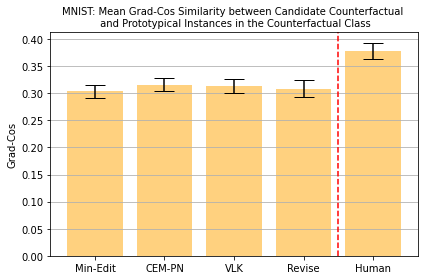

In [29]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, cos_mean, yerr=cos_sem, align='center', alpha=0.5, ecolor='black', capsize=10, color='orange', hatch='')
ax.set_ylabel('Grad-Cos', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.set_title('MNIST: Mean Grad-Cos Similarity between Candidate Counterfactual \n and Prototypical Instances in the Counterfactual Class', fontsize = 10)
ax.yaxis.grid(True)

plt.axvline(x = 3.5, color = 'r', linestyle= '--')

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars_grad_cos_MNIST.pdf')
plt.show()

#### Quickdraw

In [30]:
# Loading the data, model and preparing the data

In [31]:
x_train_qd = np.load('quickdraw_x_train.npy')
y_train_qd = np.load('quickdraw_y_train.npy')
x_test_qd = np.load('quickdraw_x_test.npy')
y_test_qd = np.load('quickdraw_y_test.npy')

In [32]:
cnn_qd = load_model('cnn_quickdraw_5_classes.h5')

In [33]:
mmd_pixel_prototype_indices_qd = np.load('../../../../../MMD-critic/quickdraw_prototype_indices_mmd_pixel_local.npy')
mmd_proto_data_qd = np.array([x_train_qd[instance] for instance in  mmd_pixel_prototype_indices.flatten()])   

In [34]:
training_indices_mmd_proto_qd = []

for class_label in range(5):
    
    training_indices_mmd_proto_qd.append([np.where(np.argmax(y_train_qd,axis=1)==class_label)[0][index] for index in mmd_pixel_prototype_indices_qd[class_label]])
    
training_indices_mmd_proto_qd = np.array(training_indices_mmd_proto_qd)


In [35]:
mmd_pixel_prototypes_qd = []

for class_label in range(5):
    
    mmd_pixel_prototypes_qd.append([x_train_qd[index] for index in training_indices_mmd_proto_qd[class_label]])
    
mmd_pixel_prototypes_qd = np.array(mmd_pixel_prototypes_qd)


In [36]:
mmd_proto_data_qd = mmd_pixel_prototypes_qd.reshape(50,28,28,1)
mmd_proto_labels_qd = np.array([y_train_qd[instance] for instance in training_indices_mmd_proto_qd.flatten()])

In [37]:
y_sample_qd = np.load('quickdraw_misclassification_indices_test_set.npy')

y_sample_qd = np.array([np.argmax(y_test_qd[instance]) for instance in y_sample_qd])

In [38]:
y_sample_qd

array([1, 4, 1, 0, 0, 2, 4, 4, 1, 0, 3, 0, 2, 3, 2, 3, 1, 4, 1, 0, 3, 1,
       3, 0, 0, 1, 2, 2, 3, 3], dtype=int64)

In [39]:
### loading the different counterfactuals from different techniques

In [40]:
quickdraw_min_edit_cf = np.load('quickdraw_min_edit_cf.npy')
quickdraw_cem_cf = np.load('quickdraw_cem_cf.npy')
quickdraw_vlk_cf = np.load('quickdraw_vlk_cf.npy')

In [41]:
human_cfe_qd = np.load('user_kmed_prototypes_quickdraw.npy')

#####  Gradient Similarity Fitting the Explainer

In [42]:
#loading in revise data for quickdraw 
revise_cfes_qd = np.load('revise_cfes_qd.npy')

In [43]:
gsm_qd = GradientSimilarity(cnn_qd, categorical_crossentropy, precompute_grads=True, sim_fn='grad_cos')

In [44]:
def cosine_similarity_quickdraw(label, technique):
    
    mean_scores_qd = []
    
    if label  == 0:
        gsm_qd.fit(mmd_proto_data_qd[label:10], mmd_proto_labels_qd[label:10])
    
    else:
        gsm_qd.fit(mmd_proto_data_qd[label*10:((label*10) +10)], mmd_proto_labels_qd[label*10:((label*10) +10)])
    
    for instance in np.where(y_sample_qd == label)[0]:
        
        expls_qd = gsm_qd.explain(technique[instance].reshape(1,28,28,1), to_categorical(y_sample_qd[instance],5))  
        
        mean_scores_qd.append(expls_qd.scores[0].mean())
        
    return mean_scores_qd

In [45]:
cos_mean_qd = []
cos_sem_qd = []

for method in [quickdraw_min_edit_cf, quickdraw_cem_cf, quickdraw_vlk_cf, revise_cfes_qd, human_cfe_qd]:
    
    score_qd = []
    for label in range(0,5):
        score_qd.append(cosine_similarity_quickdraw(label, method))
    scores_qd = list(itertools.chain.from_iterable(score_qd))
    cos_mean_qd.append(np.array(scores_qd).mean())
    cos_sem_qd.append(stats.sem(np.array(scores_qd)))

In [46]:
methods_qd = ['Min-Edit', 'CEM-PN', 'VLK','Revise', 'Human']
x_pos = np.arange(len(methods_qd))

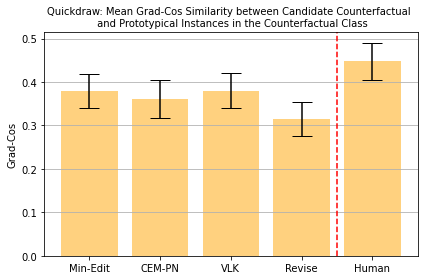

In [47]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, cos_mean_qd, yerr=cos_sem_qd, align='center', alpha=0.5, ecolor='black', capsize=10, color='orange', hatch='')
ax.set_ylabel('Grad-Cos', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods_qd)
ax.set_title('Quickdraw: Mean Grad-Cos Similarity between Candidate Counterfactual \n and Prototypical Instances in the Counterfactual Class', fontsize = 10)
ax.yaxis.grid(True)

plt.axvline(x = 3.5, color = 'r', linestyle= '--')
# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars_grad_cos_qd.pdf')
plt.show()